In [1]:
import os
import pandas as pd
import jax.numpy as jnp
import numpy as np

data_path = os.path.join("./datasets/")

In [2]:
# @title prepare_training_data
def prepare_training_data(data, n_obs):
  df_train = data.head(n_obs)
  df_test = data.tail(40)

  x_train, y_train, f_train = df_train, df_train.pop("y"), df_train.pop("f")
  x_test, y_test, f_test = df_test, df_test.pop("y"), df_test.pop("f")

  x_train = x_train.to_numpy()
  x_test = x_test.to_numpy()

  y_train = y_train.to_numpy().reshape(-1, 1).ravel()
  y_test = y_test.to_numpy().reshape(-1, 1).ravel()  
  return x_train, y_train, x_test, y_test

In [14]:
dataset_name = 'adult' # @param ['cat', 'cont', 'adult', 'heart', 'mi'] 
outcome_type = 'matern32' # @param ['linear', 'rbf', 'matern32', 'complex']
n_obs = 500 # @param [100, 200, 500, 1000]
dim_in = 50 # @param [25, 50, 100, 200]
rep = 7 # @param 

data_file = f"{outcome_type}_n{n_obs}_d{dim_in}_i{rep}.csv"
data_file_path = os.path.join(data_path, dataset_name, data_file)
print(f"Data '{data_file}'", end='\t', flush=True)  

data = pd.read_csv(data_file_path, index_col=0)  
x_train, y_train, x_test, y_test = prepare_training_data(data, n_obs)

Data 'matern32_n500_d50_i7.csv'	

In [15]:
from vie import get_fdt_model
fdt_out = get_fdt_model(x_train, y_train, c=0.1, sig2=0.01, n_tree=20, 
                            compute_psi=True, batch_size=20, n_samp=10, seed=0)

In [16]:
f = fdt_out[1]
map_matrix = fdt_out[3]["map_matrix"]
feature = fdt_out[3]["feature"]
threshold = fdt_out[3]["threshold"]
beta = fdt_out[3]["beta"]
pred_test = np.array(f(x_test, map_matrix, feature, threshold, beta))
np.mean((y_test - np.mean(pred_test, 1)) ** 2)

98.03859110836284

In [17]:
grad_fs = fdt_out[2]
betas = fdt_out[3]["betas"]
psi_est = np.array(grad_fs(x_test, map_matrix, feature, threshold, betas))
grad_train = np.mean(psi_est, axis=(0,1))
psi_test = np.median(grad_train, axis=0)

In [18]:
from jax import vmap
from jax.numpy import outer
#grad_train = fdt_out[0]
vouter = vmap(outer)
H_hat = jnp.mean(vouter(grad_train, grad_train), axis = 0)

In [19]:
y = jnp.linalg.eig(H_hat)[0]
y_diag = jnp.diagonal(H_hat)
y_diag = jnp.sort(y_diag)[::-1]

/Users/yangxinyuxie/miniforge3/envs/venv/lib/python3.10/site-packages/jax/_src/array.py:351: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


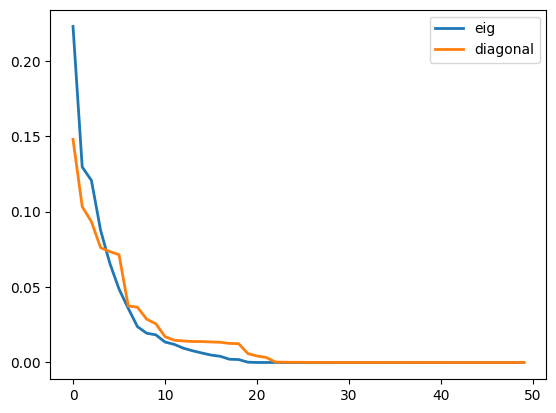

In [20]:
import matplotlib.pyplot as plt
x = np.linspace(0, dim_in-1, dim_in)

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0, label = "eig")
ax.plot(x, y_diag, linewidth=2.0, label = "diagonal")
plt.legend()

plt.show()